# Binary Classification Model for Loan Default Dataset Using Scikit-learn
### David Lowe
### February 7, 2022

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Loan Default dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: The dataset owner leveraged another source from Kaggle to create a dataset for predicting loan default. The dataset contains the past data on the loan borrowers, and we would develop a machine learning model to classify whether any new borrower is likely to default.

ANALYSIS: The average performance of the machine learning algorithms achieved a ROC/AUC benchmark of 0.9932 using the training dataset. Furthermore, we selected Random Forest as the final model as it processed the training dataset with a final ROC/AUC score of 1.0. When we processed the test dataset with the final model, the model also achieved a ROC/AUC score of 1.0.

CONCLUSION: In this iteration, the Random Forest model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Loan Default Dataset by M Yasser H

Dataset ML Model: Binary classification with numerical and categorical features

Dataset Reference: https://www.kaggle.com/yasserh/loan-default-dataset

## Task 1 - Prepare Environment

In [1]:
# Retrieve memory configuration information
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 31.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 8


In [3]:
# # Mount Google Drive locally for loading the dotenv files
# from dotenv import load_dotenv
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

### 1.a) Load libraries and modules

In [4]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

### 1.b) Set up the controlling parameters and functions

In [6]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.15
VAL_SET_RATIO = 0.15

# Set the number of folds for cross validation
N_FOLDS = 5

# Define the directory locations and file names
# STAGING_DIR = ''
# TRAIN_DIR = ''
# VALID_DIR = ''
# TEST_DIR = ''
TRAIN_DATASET = 'Loan_Default.csv'
# VALID_DATASET = ''
# TEST_DATASET = ''
# TRAIN_LABELS = ''
# VALID_LABELS = ''
# TEST_LABELS = ''
# OUTPUT_DIR = 'staging/'
# SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
# FINAL_SUBMISSION_CSV = 'submission.csv'

# Set default modeling scoring metric
SCORING_METRIC = 'roc_auc'

In [7]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [8]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [9]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-loan-default-m_yasser_h/Loan_Default.csv

In [10]:
df_dataset_import = pd.read_csv(TRAIN_DATASET,index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head(10))

      ID  year loan_limit             Gender approv_in_adv loan_type  \
0  24890  2019         cf  Sex Not Available         nopre     type1   
1  24891  2019         cf               Male         nopre     type2   
2  24892  2019         cf               Male           pre     type1   
3  24893  2019         cf               Male         nopre     type1   
4  24894  2019         cf              Joint           pre     type1   
5  24895  2019         cf              Joint           pre     type1   
6  24896  2019         cf              Joint           pre     type1   
7  24897  2019        NaN             Female         nopre     type1   
8  24898  2019         cf              Joint         nopre     type1   
9  24899  2019         cf  Sex Not Available         nopre     type3   

  loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
0           p1                l1        nopc                  nob/c  ...   
1           p1                l1        nopc           

In [11]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [12]:
print(df_dataset_import.describe())

                  ID      year   loan_amount  rate_of_interest  \
count  148670.000000  148670.0  1.486700e+05     112231.000000   
mean    99224.500000    2019.0  3.311177e+05          4.045476   
std     42917.476598       0.0  1.839093e+05          0.561391   
min     24890.000000    2019.0  1.650000e+04          0.000000   
25%     62057.250000    2019.0  1.965000e+05          3.625000   
50%     99224.500000    2019.0  2.965000e+05          3.990000   
75%    136391.750000    2019.0  4.365000e+05          4.375000   
max    173559.000000    2019.0  3.576500e+06          8.000000   

       Interest_rate_spread  Upfront_charges           term  property_value  \
count         112031.000000    109028.000000  148629.000000    1.335720e+05   
mean               0.441656      3224.996127     335.136582    4.978935e+05   
std                0.513043      3251.121510      58.409084    3.599353e+05   
min               -3.638000         0.000000      96.000000    8.000000e+03   
25%       

In [13]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

ID                               0
year                             0
loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
term                            41
Neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        9150
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            200
submission_of_applic

In [14]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('Status').size())

Status
0    112031
1     36639
dtype: int64


### 1.d) Data Cleaning

In [15]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={'Status': 'target'})

# Dropping features
df_dataset_import.drop(columns=['ID','year'], inplace=True)

# Impute missing values
# df_dataset_import['col_name'].fillna('someValue', inplace=True)
# df_dataset_import['col_name'].fillna(value=df_dataset_import['col_name'].median(), inplace=True)

# Convert columns from one data type to another
# df_dataset_import.column_name = df_dataset_import.column_name.astype('int')
# df_dataset_import.column_name = df_dataset_import.column_name.astype('category')

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head(10))

  loan_limit             Gender approv_in_adv loan_type loan_purpose  \
0         cf  Sex Not Available         nopre     type1           p1   
1         cf               Male         nopre     type2           p1   
2         cf               Male           pre     type1           p1   
3         cf               Male         nopre     type1           p4   
4         cf              Joint           pre     type1           p1   
5         cf              Joint           pre     type1           p1   
6         cf              Joint           pre     type1           p3   
7        NaN             Female         nopre     type1           p4   
8         cf              Joint         nopre     type1           p3   
9         cf  Sex Not Available         nopre     type3           p3   

  Credit_Worthiness open_credit business_or_commercial  loan_amount  \
0                l1        nopc                  nob/c       116500   
1                l1        nopc                    b/c       2065

In [16]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_limit                 145326 non-null  object 
 1   Gender                     148670 non-null  object 
 2   approv_in_adv              147762 non-null  object 
 3   loan_type                  148670 non-null  object 
 4   loan_purpose               148536 non-null  object 
 5   Credit_Worthiness          148670 non-null  object 
 6   open_credit                148670 non-null  object 
 7   business_or_commercial     148670 non-null  object 
 8   loan_amount                148670 non-null  int64  
 9   rate_of_interest           112231 non-null  float64
 10  Interest_rate_spread       112031 non-null  float64
 11  Upfront_charges            109028 non-null  float64
 12  term                       148629 non-null  float64
 13  Neg_ammortization          14

In [17]:
print(df_dataset_import.describe())

        loan_amount  rate_of_interest  Interest_rate_spread  Upfront_charges  \
count  1.486700e+05     112231.000000         112031.000000    109028.000000   
mean   3.311177e+05          4.045476              0.441656      3224.996127   
std    1.839093e+05          0.561391              0.513043      3251.121510   
min    1.650000e+04          0.000000             -3.638000         0.000000   
25%    1.965000e+05          3.625000              0.076000       581.490000   
50%    2.965000e+05          3.990000              0.390400      2596.450000   
75%    4.365000e+05          4.375000              0.775400      4812.500000   
max    3.576500e+06          8.000000              3.357000     60000.000000   

                term  property_value         income   Credit_Score  \
count  148629.000000    1.335720e+05  139520.000000  148670.000000   
mean      335.136582    4.978935e+05    6957.338876     699.789103   
std        58.409084    3.599353e+05    6496.586382     115.875857   

In [18]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
term                            41
Neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        9150
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            200
submission_of_application      200
LTV                          15098
Region              

In [19]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('target').size())

target
0    112031
1     36639
dtype: int64


### 1.e) Splitting Data into Sets

In [20]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_import = df_dataset_import['target']
df_features_import = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_import.shape: {} df_target_import.shape: {}".format(df_dataset_import.shape, df_features_import.shape, df_target_import.shape))

df_dataset_import.shape: (148670, 32) df_features_import.shape: (148670, 31) df_target_import.shape: (148670,)


In [21]:
# Split the data further into training and test datasets
df_features_train, df_features_test, df_target_train, df_target_test = train_test_split(df_features_import, df_target_import,
                                                                                        test_size=TEST_SET_RATIO, random_state=RNG_SEED,
                                                                                        stratify=df_target_import)
print("df_features_train.shape: {} df_target_train.shape: {}".format(df_features_train.shape, df_target_train.shape))
print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

df_features_train.shape: (126369, 31) df_target_train.shape: (126369,)
df_features_test.shape: (22301, 31) df_target_test.shape: (22301,)


### 1.f) Set up the parameters for data visualization

In [22]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [23]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [24]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

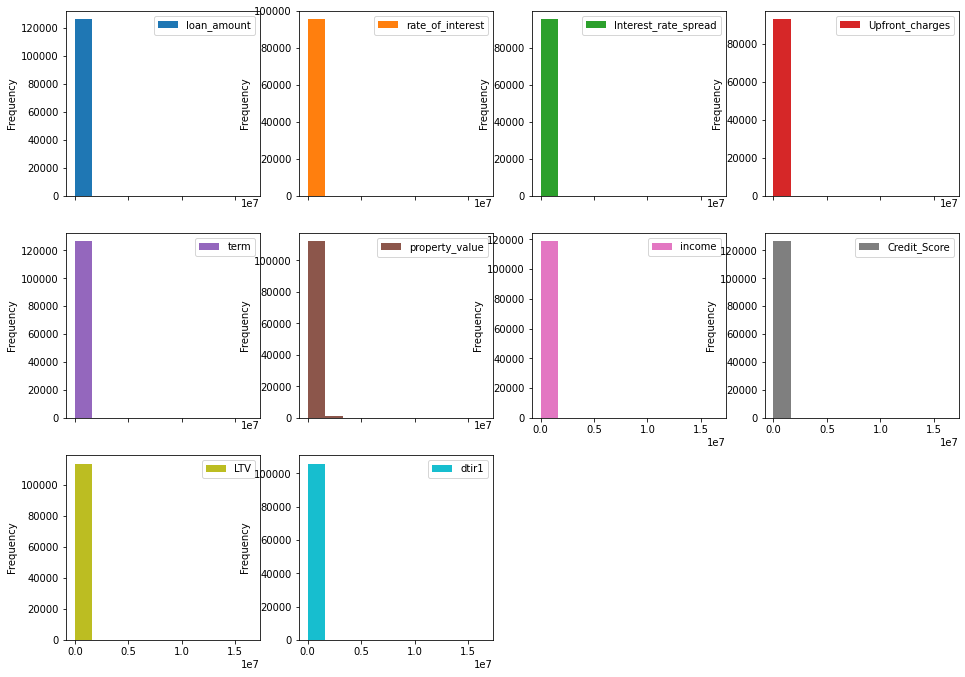

In [25]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

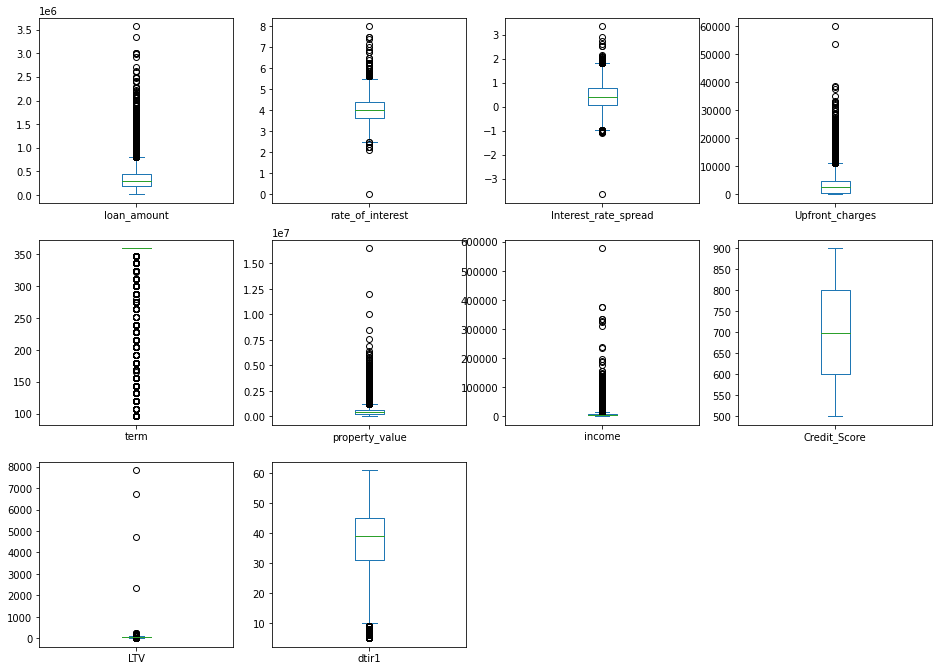

In [26]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

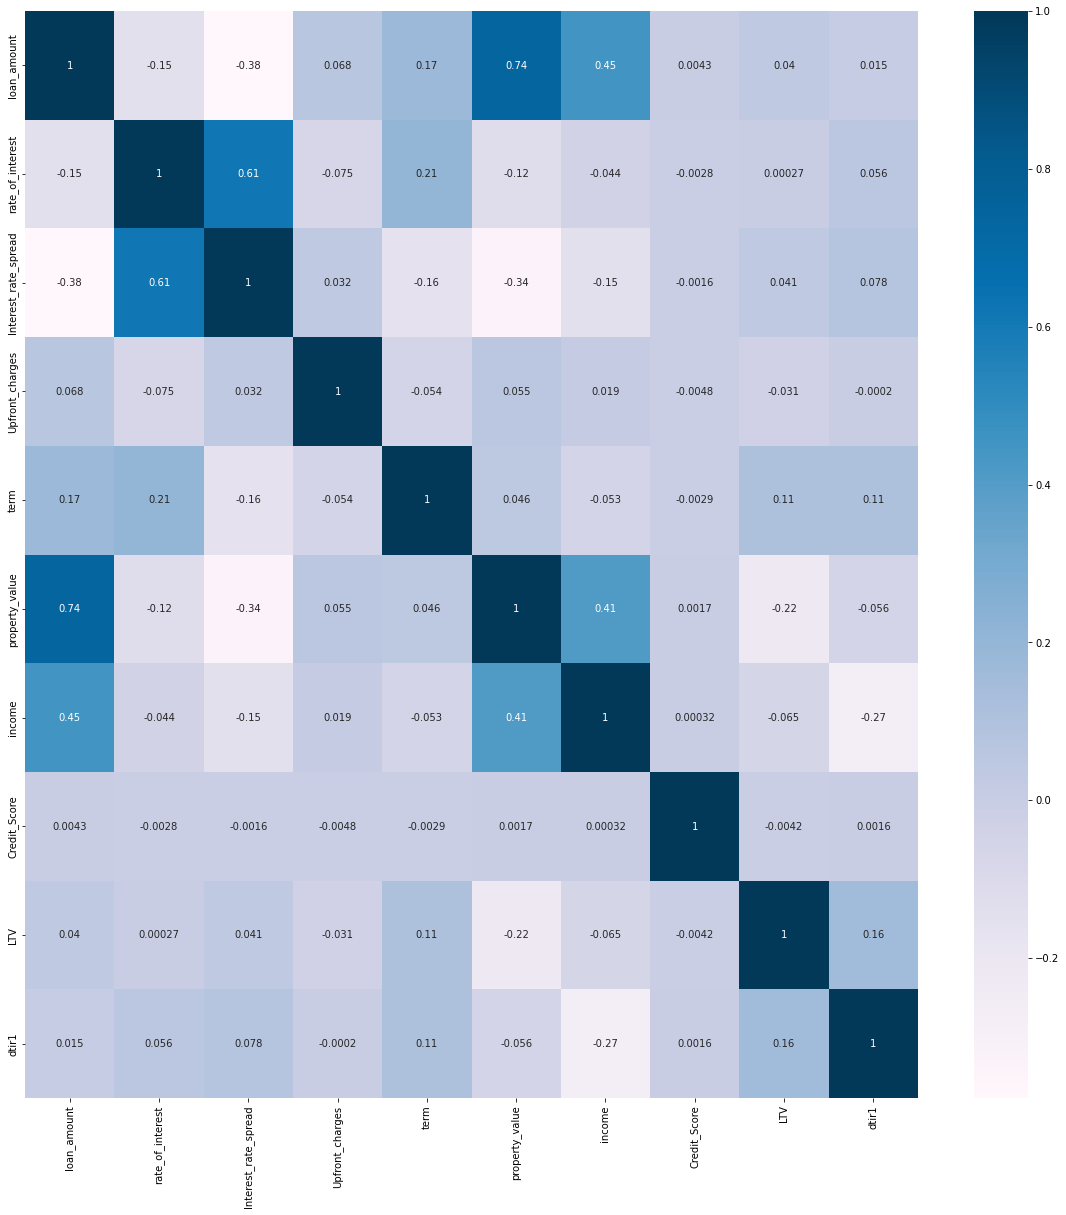

In [27]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [28]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [29]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [30]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 10
Number of categorical columns: 21
Total number of columns in the feature dataframe: 31


In [31]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (126369, 31) to array_features_train.shape: (126369, 75)


### 3.b) Training Data Balancing

In [32]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [33]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [34]:
# Finalize the training dataset for the modeling activities
# array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.ravel()
# label_encoder = preprocessing.LabelEncoder()
# array_target_train = label_encoder.fit_transform(df_target_train)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (126369, 75) array_target_train.shape: (126369,)


In [35]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [36]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [37]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []

In [38]:
train_models.append(('LGR', LogisticRegression(solver='saga', random_state=RNG_SEED)))
train_models.append(('CART', DecisionTreeClassifier(random_state=RNG_SEED)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=N_JOBS)))
train_models.append(('BGT', BaggingClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('RNF', RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))

In [39]:
# Generate model in turn
for name, model in train_models:
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	start_time_module = datetime.now()
	kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
	cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - start_time_module), '\n')
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics (' + SCORING_METRIC + ') from all models:', np.mean(train_metrics))
print ('Total training time for all models:', (datetime.now() - start_time_training))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   58.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LGR: 0.999998 (0.000003)
LogisticRegression(random_state=888, solver='saga')
Model training time: 0:00:58.052847 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CART: 0.999995 (0.000011)
DecisionTreeClassifier(random_state=888)
Model training time: 0:00:02.232114 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KNN: 0.959277 (0.001157)
KNeighborsClassifier(n_jobs=1)
Model training time: 0:04:36.648838 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BGT: 0.999995 (0.000011)
BaggingClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:11.733321 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RNF: 1.000000 (0.000000)
RandomForestClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:31.378432 

EXT: 1.000000 (0.000000)
ExtraTreesClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:52.303676 

Average metrics (roc_auc) from all models: 0.9932108449337561
Total training time for all models: 0:07:12.361315


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   52.3s finished


### 4.b) Spot-checking baseline algorithms

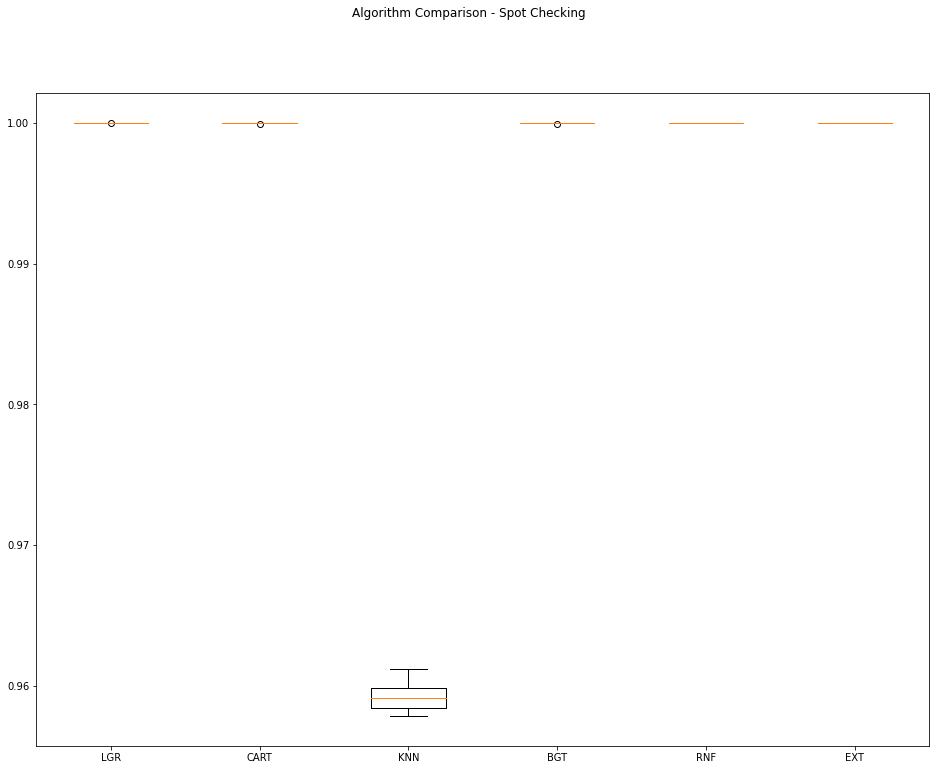

In [40]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

### 4.c) Algorithm Tuning

In [41]:
# Not applicable for this iteration of the project

### 4.d) Compare Algorithms After Tuning

In [42]:
# Not applicable for this iteration of the project

In [43]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [44]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [45]:
final_model = RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)
final_model.fit(array_features_train, array_target_train)
print(final_model)

RandomForestClassifier(n_jobs=1, random_state=888)


### 5.b) Load Test Dataset and Make Predictions

In [46]:
# Finalize the test dataset for the testing activities
array_features_test = preprocessor.transform(df_features_test)
array_target_test = df_target_test.ravel()
print("array_features_test.shape: {} array_target_test.shape: {}".format(array_features_test.shape, array_target_test.shape))

array_features_test.shape: (22301, 75) array_target_test.shape: (22301,)


In [47]:
# Make batched predictions
test_predictions = final_model.predict(array_features_test)
print(test_predictions)

[0 0 1 ... 0 0 0]


In [48]:
print('Accuracy Score:', accuracy_score(array_target_test, test_predictions))
print('ROC/AUC Score:', roc_auc_score(array_target_test, test_predictions))
print(confusion_matrix(array_target_test, test_predictions))
print(classification_report(array_target_test, test_predictions))

Accuracy Score: 1.0
ROC/AUC Score: 1.0
[[16805     0]
 [    0  5496]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16805
           1       1.00      1.00      1.00      5496

    accuracy                           1.00     22301
   macro avg       1.00      1.00      1.00     22301
weighted avg       1.00      1.00      1.00     22301



In [49]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [50]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:07:28.468190
